### Using the PyPEF API functionalities
successfully tested with Python 3.10 running on Windows and Linux (not WSL2 due to TensorFlow issues)

In [1]:
from IPython.display import Image, display

import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import KFold, train_test_split

# pypef imports
from pypef import __version__
from pypef.utils.variant_data import get_seqs_from_var_name
from pypef.ml.regression import (
    OneHotEncoding, AAIndexEncoding, get_regressor_performances,
    path_aaindex_dir, full_aaidx_txt_path
)
from pypef.dca.hybrid_model import DCAHybridModel, remove_gap_pos, get_delta_e_statistical_model
from pypef.dca.plmc_encoding import PLMC
from pypef.dca.gremlin_inference import GREMLIN

2023-08-30 11:04:44.046935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 11:04:44.274228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 11:04:44.275628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 11:04:45.192190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
__version__  # pypef version

'0.3.2-alpha'

In [3]:
n_aaindices_to_test = 10  # all would be 566 AAindex indices, only testing 10 here for shorter run time
# avGFP wild type sequence
wt_sequence = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL' \
              'VTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLV' \
              'NRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD' \
              'HYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

In [4]:
variant_fitness_data = pd.read_csv('../../datasets/AVGFP/avGFP.csv', sep=';')  # loading the avGFP dataset

variants = variant_fitness_data.iloc[:2000, 0].values  # "just" using 2000 variants for faster processing
fitnesses = variant_fitness_data.iloc[:2000, 1].values
variants_split = []
for variant in variants:
    variants_split.append(variant.split('/'))
variants, fitnesses, sequences = get_seqs_from_var_name(wt_sequence, variants_split, fitnesses)

# Splitting in sets for training (fitting and hyperparameter validation) and testing
# Change number of applied splits for training and testing here, default: n_splits = 5
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
train_val_splits_indices, test_splits_indices = [], []

In [5]:
dca_encoder = GREMLIN(
    alignment='../../datasets/AVGFP/uref100_avgfp_jhmmer_119.a2m',
    wt_seq=wt_sequence,
    opt_iter=100,
    optimize=True
)

2023-08-30 11:04:47.025782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 11:04:47.026112: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-30 11:04:47.031006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


In [6]:
dca_encoder.plot_correlation_matrix(matrix_type='apc')

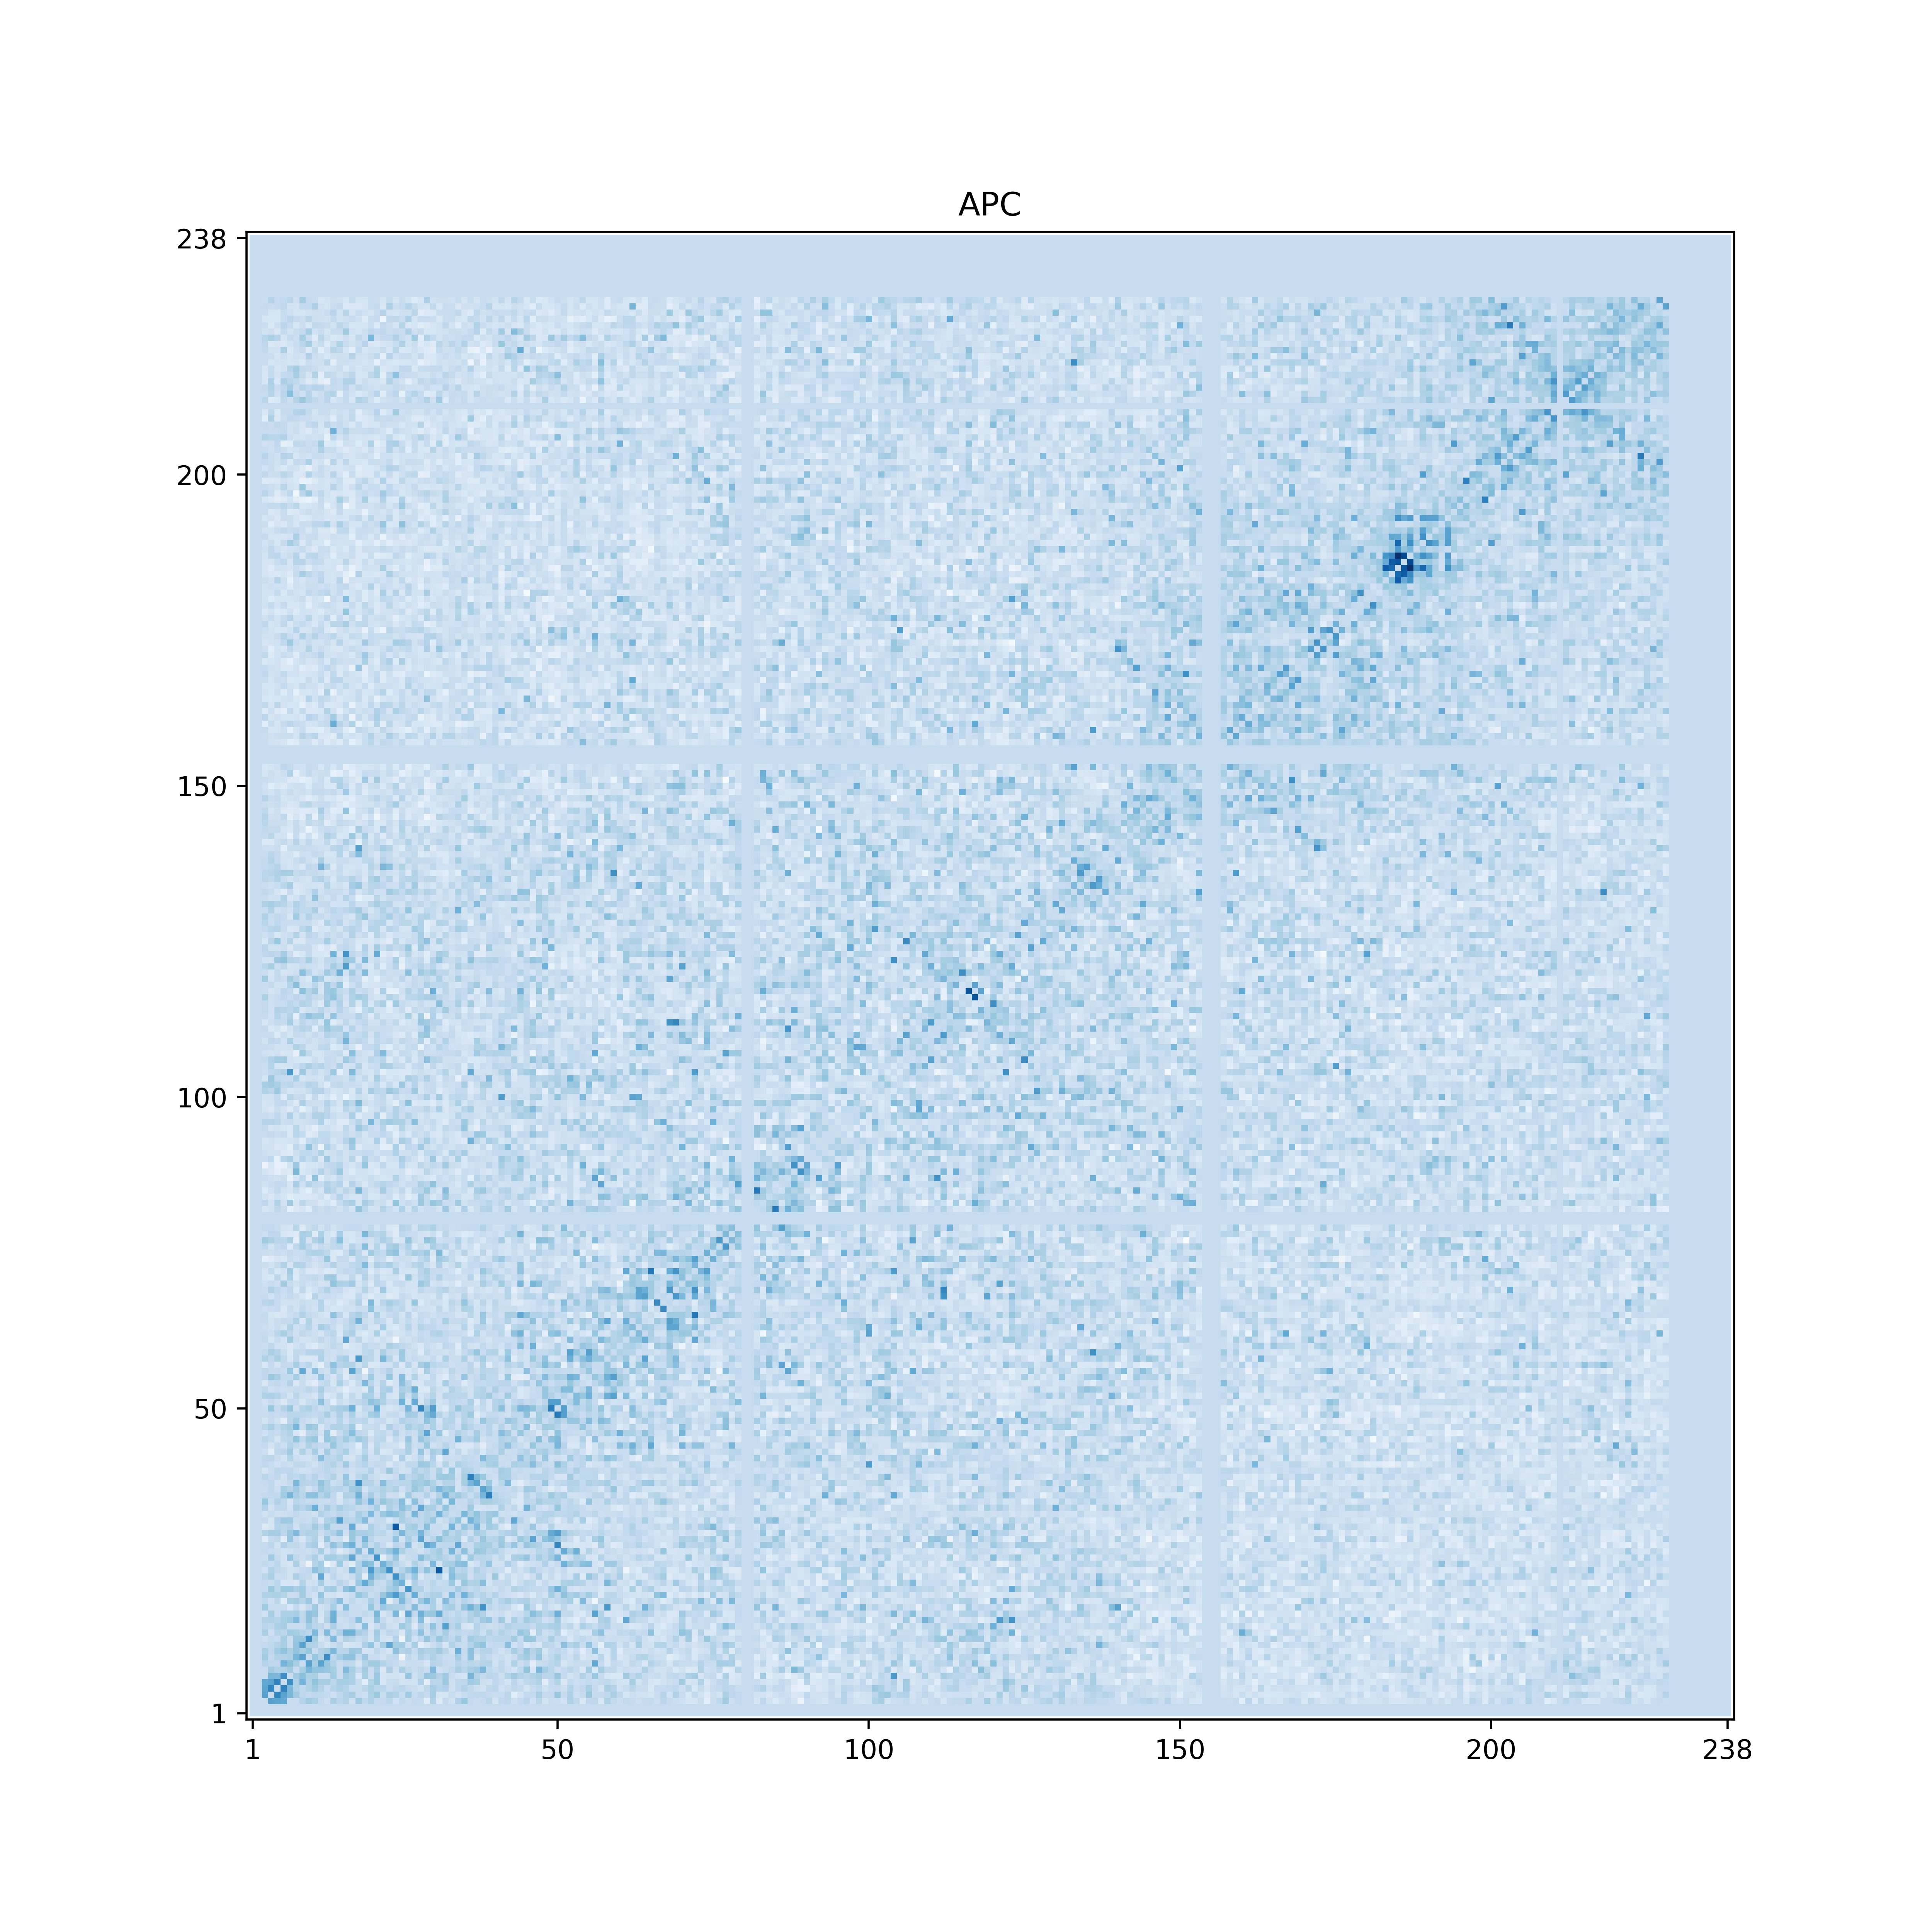

In [7]:
display(Image(filename='apc.png', width=500))

In [8]:
gaps = dca_encoder.gaps
variants, sequences, fitnesses = remove_gap_pos(gaps, variants, sequences, fitnesses)
x_dca = dca_encoder.collect_encoded_sequences(sequences)
x_wt = dca_encoder.x_wt

In [9]:
# Statistical model performance
y_pred = get_delta_e_statistical_model(x_dca, x_wt)
print(f'Statistical DCA model performance on all (2000) datapoints: Spearman rho = {spearmanr(fitnesses, y_pred)[0]:.3f}')
# Split double and higher substituted variants to multiple single substitutions separated by '/'

print(f'N Variants remaining after excluding non-DCA-encodable positions: {len(x_dca)}')
assert len(x_dca) == len(fitnesses) == len(variants) == len(sequences)

Statistical DCA model performance on all (2000) datapoints: Spearman rho = 0.697
N Variants remaining after excluding non-DCA-encodable positions: 1981


In [10]:
for train_val_indices, test_indices in kf.split(variants):  # several variants are not included in the data anymore
    train_val_splits_indices.append(train_val_indices)
    test_splits_indices.append(test_indices)
print(f'Total number of variant-fitness data for training and '
      f'validation-based hyperparameter tuning: {len(train_val_indices)}'  # indices only vary by +- 1 for the splits
      f'\nVariants for testing: {len(test_indices)}\n')

Total number of variant-fitness data for training and validation-based hyperparameter tuning: 1585
Variants for testing: 396



In [11]:
ten_split_performance_ml, ten_split_performance_hybrid = [], []
for i, indices in enumerate(train_val_splits_indices):
    x_train_val = np.array(x_dca)[indices]
    y_train_val = np.array(fitnesses)[indices]
    x_test = np.array(x_dca)[test_splits_indices[i]]
    y_test = np.array(fitnesses)[test_splits_indices[i]]
    # get_regressor_performances() already splits train_val data in data for fitting (training) and validation
    # and after each CV-round shifts to the next hyperparameter of the regressor hyperparameter grid
    performances = get_regressor_performances(x_train_val, x_test, y_train_val, y_test, regressor='ridge')
    # performances[4] is Spearmans correlation between y_true and y_pred
    ten_split_performance_ml.append(performances[4])
    print(f'Split {i + 1}/{len(train_val_splits_indices)}:\nSpearmans rho (ML) = {performances[4]:.3f}')
    # B. Hybrid modeling
    # -------------------------------------------------------------------------------
    hybrid_model = DCAHybridModel(x_train=x_train_val, y_train=y_train_val, x_wt=x_wt)
    beta_1, beta_2, regressor = hybrid_model.settings(x_train=x_train_val, y_train=y_train_val)
    y_test_pred = hybrid_model.hybrid_prediction(x=x_test, reg=regressor, beta_1=beta_1, beta_2=beta_2)
    ten_split_performance_hybrid.append(spearmanr(y_test, y_test_pred)[0])
    print(f'Spearmans rho (Hybrid) = {spearmanr(y_test, y_test_pred)[0]:.3f}')
print('-'*80 + f'\n{n_splits}-fold mean Spearmans rho (ML) = {np.mean(ten_split_performance_ml):.3f} '
      f'+- {np.std(ten_split_performance_ml, ddof=1):.3f}\n'
      f'{n_splits}-fold mean Spearmans rho (Hybrid) = {np.mean(ten_split_performance_hybrid):.3f} '
      f'+- {np.std(ten_split_performance_ml, ddof=1):.3f}')

Split 1/5:
Spearmans rho (ML) = 0.787
Spearmans rho (Hybrid) = 0.785
Split 2/5:
Spearmans rho (ML) = 0.805
Spearmans rho (Hybrid) = 0.803
Split 3/5:
Spearmans rho (ML) = 0.835
Spearmans rho (Hybrid) = 0.824
Split 4/5:
Spearmans rho (ML) = 0.819
Spearmans rho (Hybrid) = 0.822
Split 5/5:
Spearmans rho (ML) = 0.801
Spearmans rho (Hybrid) = 0.803
--------------------------------------------------------------------------------
5-fold mean Spearmans rho (ML) = 0.809 +- 0.018
5-fold mean Spearmans rho (Hybrid) = 0.807 +- 0.018


In [12]:
# 2nd example: AAindex encoding over all 566 amino acid descriptor sets
# -------------------------------------------------------------------------------
print(f'\n\n(2/4) Testing AAindex-based sequence encoding (using {n_aaindices_to_test} indices)...\n' + "=" * 75)
spearmans_rhos_aaidx, aa_index = [], []
# e.g., looping over the (up to 566) AAindex entries, encode with each AAindex and test performance
# which can be seen as a AAindex hyperparameter search on the test set, i.e.,
# not totally fair comparison to onehot- and DCA-based encoding techniques.
# Limiting indices for testing to N = n_aaindices_to_test...
aa_indices = sorted([file for file in os.listdir(path_aaindex_dir()) if file.endswith('.txt')])[:n_aaindices_to_test]
mean_performances, ten_split_performance_std_dev, aa_indices_collected = [], [], []
for index, aaindex in enumerate(aa_indices):
    aaidx_encoder = AAIndexEncoding(full_aaidx_txt_path(aaindex), sequences)
    # two encoding options possible, FFT-ed and 'raw' encoded sequences (here we keep using 'raw' encoded sequences)
    x_aaidx_fft, x_aaidx_no_fft = aaidx_encoder.collect_encoded_sequences()
    ten_split_performance = []
    if x_aaidx_no_fft == 'skip':
        print(f'Skipped AAindex {aaindex}')
        continue
    for i, indices in enumerate(train_val_splits_indices):
        print(f'\rSplit {i+1}/{len(train_val_splits_indices)}', end='')
        x_train_val = np.array(x_aaidx_no_fft)[indices]
        y_train_val = np.array(fitnesses)[indices]
        x_test = np.array(x_aaidx_no_fft)[test_splits_indices[i]]
        y_test = np.array(fitnesses)[test_splits_indices[i]]
        performances = get_regressor_performances(x_train_val, x_test, y_train_val, y_test, regressor='ridge')
        ten_split_performance.append(performances[4])
    print(f'\r{index + 1}/{len(aa_indices)}: AAindex {aaindex}, '
          f'{n_splits}-fold mean Spearmans rho = {np.mean(ten_split_performance):.3f} '
          f'+- {np.std(ten_split_performance, ddof=1):.3f}')
    mean_performances.append(np.mean(ten_split_performance))

    ten_split_performance_std_dev.append(np.std(ten_split_performance, ddof=1))
    aa_indices_collected.append(aaindex)
max_value = max(mean_performances)
max_idx = mean_performances.index(max_value)
max_value_std = ten_split_performance_std_dev[max_idx]
max_value_aaidx = aa_indices_collected[max_idx]
print('-'*80 + f'\nBest {n_splits}-fold mean Spearmans rho = {max_value:.3f} '
      f'+- {max_value_std:.3f}, AAindex descriptor set = {max_value_aaidx}\n')



(2/4) Testing AAindex-based sequence encoding (using 10 indices)...
1/10: AAindex ANDN920101.txt, 5-fold mean Spearmans rho = 0.707 +- 0.015
2/10: AAindex ARGP820101.txt, 5-fold mean Spearmans rho = 0.551 +- 0.080
3/10: AAindex ARGP820102.txt, 5-fold mean Spearmans rho = 0.666 +- 0.035
4/10: AAindex ARGP820103.txt, 5-fold mean Spearmans rho = 0.673 +- 0.035
5/10: AAindex AURR980101.txt, 5-fold mean Spearmans rho = 0.668 +- 0.031
6/10: AAindex AURR980102.txt, 5-fold mean Spearmans rho = 0.670 +- 0.025
7/10: AAindex AURR980103.txt, 5-fold mean Spearmans rho = 0.621 +- 0.025
8/10: AAindex AURR980104.txt, 5-fold mean Spearmans rho = 0.573 +- 0.026
9/10: AAindex AURR980105.txt, 5-fold mean Spearmans rho = 0.568 +- 0.031
10/10: AAindex AURR980106.txt, 5-fold mean Spearmans rho = 0.718 +- 0.019
--------------------------------------------------------------------------------
Best 5-fold mean Spearmans rho = 0.718 +- 0.019, AAindex descriptor set = AURR980106.txt



In [13]:
# 3rd example: OneHot encoding
# -------------------------------------------------------------------------------
print('\n(3/4) Testing OneHot sequence encoding...\n' + "=" * 50)
onehot_encoder = OneHotEncoding(sequences)
x_onehot = onehot_encoder.collect_encoded_sequences()
ten_split_performance = []
for i, indices in enumerate(train_val_splits_indices):
    x_train_val = np.array(x_onehot)[indices]
    y_train_val = np.array(fitnesses)[indices]
    x_test = np.array(x_onehot)[test_splits_indices[i]]
    y_test = np.array(fitnesses)[test_splits_indices[i]]
    performances = get_regressor_performances(x_train_val, x_test, y_train_val, y_test, regressor='ridge')
    ten_split_performance.append(performances[4])
    print(f'Split {i + 1}/{len(train_val_splits_indices)}: Spearmans rho = {performances[4]:.3f}')
print('-'*80 + f'\n{n_splits}-fold mean Spearmans rho = {np.mean(ten_split_performance):.3f} '
      f'+- {np.std(ten_split_performance, ddof=1):.3f}\n')


(3/4) Testing OneHot sequence encoding...


100%|██████████| 1981/1981 [00:03<00:00, 524.97it/s]


Split 1/5: Spearmans rho = 0.779
Split 2/5: Spearmans rho = 0.824
Split 3/5: Spearmans rho = 0.842
Split 4/5: Spearmans rho = 0.816
Split 5/5: Spearmans rho = 0.820
--------------------------------------------------------------------------------
5-fold mean Spearmans rho = 0.816 +- 0.023



In [14]:
# 4th example: Low-N and plotting using all encoding techniques and all data
# -------------------------------------------------------------------------------
print('Lastly, encoding all variants and performing "low-N" protein engineering task.\n'
      'This could require some time... < 1 h for GREMLIN DCA-based encoding left...')

variants = variant_fitness_data.iloc[:, 0]
fitnesses = variant_fitness_data.iloc[:, 1].tolist()
variants_split = []
for variant in variants:
    variants_split.append(variant.split('/'))
variants, fitnesses, sequences = get_seqs_from_var_name(wt_sequence, variants_split, fitnesses)
print(f'N Total variants = {len(variants)}.\nEncoding sequences...')

variants, sequences, fitnesses = remove_gap_pos(dca_encoder.gaps, variants, sequences, fitnesses)
x_dca = dca_encoder.get_score(sequences, encode=True)

print(f'N Variants remaining after excluding non-DCA-encodable positions = {len(x_dca)}')

# using the best identified index, i.e., AURR980106 for 10 tested indices or QIAN880130 for all 566 indices
print(f'AAIndex-based encoding of the {len(x_dca)} variants (using index {max_value_aaidx})...')
x_aaindex_fft, x_aaindex_no_fft = AAIndexEncoding(
    full_aaidx_txt_path(max_value_aaidx), sequences).collect_encoded_sequences()
print(f'One-hot encoding of the {len(x_dca)} variants...')
x_onehot = OneHotEncoding(sequences).collect_encoded_sequences()

assert len(x_dca) == len(x_aaindex_no_fft) == len(x_onehot) == len(fitnesses) == len(variants) == len(sequences)

Lastly, encoding all variants and performing "low-N" protein engineering task.
This could require some time... < 1 h for GREMLIN DCA-based encoding left...
N Total variants = 51714.
Encoding sequences...
N Variants remaining after excluding non-DCA-encodable positions = 51552
AAIndex-based encoding of the 51552 variants (using index AURR980106.txt)...
One-hot encoding of the 51552 variants...


100%|██████████| 51552/51552 [01:38<00:00, 523.25it/s]


In [15]:
all_mean_performances_dca, all_mean_performances_hybrid, \
    all_mean_performances_aaidx, all_mean_performances_onehot = [], [], [], []
all_stddevs_dca, all_stddevs_hybrid, all_stddevs_aaidx, all_stddevs_onehot = [], [], [], []
low_n_train = np.arange(50, 1001, 50)
print(f'\n(4/4) Testing low N performance (with N_train = {list(low_n_train)})...\n' + "=" * 50)
for n_train in tqdm(low_n_train):
    performances_dca, performances_hybrid, performances_aaidx, performances_onehot = [], [], [], []
    for rnd_state in [42, 213, 573, 917, 823]:
        x_dca_train, x_dca_test, y_train, y_test = train_test_split(
            x_dca, fitnesses, train_size=n_train, random_state=rnd_state)
        performances_dca.append(get_regressor_performances(
            x_dca_train, x_dca_test, y_train, y_test, regressor='ridge')[4])  # [4] defines spearmanr correlation

        hybrid_model = DCAHybridModel(x_train=x_dca_train, y_train=y_train, x_wt=x_wt)
        beta_1, beta_2, hybrid_regressor = hybrid_model.settings(x_train=x_dca_train, y_train=y_train)
        y_hybrid_pred = hybrid_model.hybrid_prediction(x=x_dca_test, reg=hybrid_regressor, beta_1=beta_1, beta_2=beta_2)
        performances_hybrid.append(spearmanr(y_test, y_hybrid_pred)[0])

        x_aaidx_train, x_aaidx_test, y_train, y_test = train_test_split(
            x_aaindex_no_fft, fitnesses, train_size=n_train, random_state=rnd_state)
        performances_aaidx.append(get_regressor_performances(
            x_aaidx_train, x_aaidx_test, y_train, y_test, regressor='ridge')[4])


        x_onehot_train, x_onehot_test, y_train, y_test = train_test_split(
            x_onehot, fitnesses, train_size=n_train, random_state=rnd_state)
        performances_onehot.append(get_regressor_performances(
            x_onehot_train, x_onehot_test, y_train, y_test, regressor='ridge')[4])

    all_mean_performances_dca.append(np.mean(performances_dca))
    all_stddevs_dca.append(np.std(performances_dca, ddof=1))
    all_mean_performances_hybrid.append(np.mean(performances_hybrid))
    all_stddevs_hybrid.append(np.std(performances_hybrid, ddof=1))
    all_mean_performances_aaidx.append(np.mean(performances_aaidx))
    all_stddevs_aaidx.append(np.std(performances_aaidx, ddof=1))
    all_mean_performances_onehot.append(np.mean(performances_onehot))
    all_stddevs_onehot.append(np.std(performances_onehot, ddof=1))


(4/4) Testing low N performance (with N_train = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])...


100%|██████████| 20/20 [54:20<00:00, 163.03s/it]


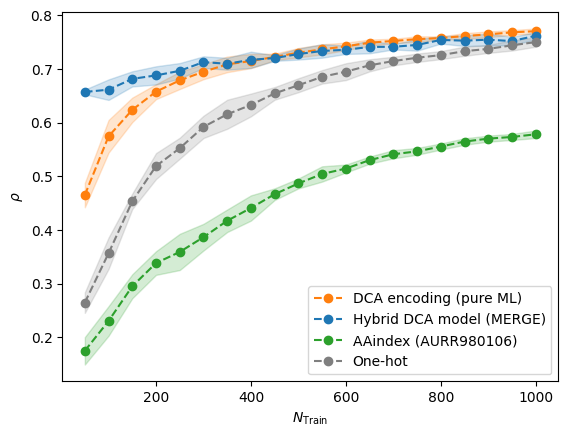


Done! Created figure 'low_N_avGFP_extrapolation.png'.


In [16]:
# Plotting all the achieved "low-N" performances
plt.plot(low_n_train, all_mean_performances_dca, 'o--', color='tab:orange', label='DCA encoding (pure ML)')
plt.fill_between(low_n_train,
                 np.array(all_mean_performances_dca) - np.array(all_stddevs_dca),
                 np.array(all_mean_performances_dca) + np.array(all_stddevs_dca),
                 color='tab:orange', alpha=0.2)
plt.plot(low_n_train, all_mean_performances_hybrid, 'o--', color='tab:blue', label='Hybrid DCA model (MERGE)')
plt.fill_between(low_n_train,
                 np.array(all_mean_performances_hybrid) - np.array(all_stddevs_hybrid),
                 np.array(all_mean_performances_hybrid) + np.array(all_stddevs_hybrid),
                 color='tab:blue', alpha=0.2)
plt.plot(low_n_train, all_mean_performances_aaidx, 'o--', color='tab:green',
         label=f"AAindex ({max_value_aaidx.split('.')[0]})")
plt.fill_between(low_n_train,
                 np.array(all_mean_performances_aaidx) - np.array(all_stddevs_aaidx),
                 np.array(all_mean_performances_aaidx) + np.array(all_stddevs_aaidx),
                 color='tab:green', alpha=0.2)
plt.plot(low_n_train, all_mean_performances_onehot, 'o--', color='tab:grey', label='One-hot')
plt.fill_between(low_n_train,
                 np.array(all_mean_performances_onehot) - np.array(all_stddevs_onehot),
                 np.array(all_mean_performances_onehot) + np.array(all_stddevs_onehot),
                 color='tab:grey', alpha=0.2)
plt.legend()
plt.xlabel(r'$N_\mathrm{Train}$')
plt.ylabel(r'$\rho$')
plt.savefig('low_N_avGFP_extrapolation.png', dpi=500)
%matplotlib inline
plt.show()
print('\nDone! Created figure \'low_N_avGFP_extrapolation.png\'.')

Done! Notebook end.